In [120]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

In [121]:


# t = np.linspace(0, 100, 1000)
# data = np.sin(t)

# def create_sequences(data, seq_length):
#     xs, ys = [], []
#     for i in range(len(data) - seq_length):
#         x = data[i:(i + seq_length)]
#         y = data[i + seq_length]
#         xs.append(x)
#         ys.append(y)
#     return np.array(xs), np.array(ys)\

# seq_length = 15
# X, y = create_sequences(data, seq_length)

# trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
# trainY = torch.tensor(y[:, None], dtype=torch.float32)




In [122]:
import csv
import os
import pandas as pd


path = os.path.join("../../data", "integrated_data_20251016_182851.csv")
df = pd.read_csv(path)


print("DataFrame shape:", df.shape)
print("Columns:", list(df.columns))
print("\nFirst 5 rows:")
print(df.head())

numeric_columns = ['iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 
                   'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

data = df[numeric_columns].values.astype(np.float32)

print(f"\nNumeric data shape: {data.shape}")
print("First 5 rows of numeric data:")
print(data[:5])



DataFrame shape: (1000, 17)
Columns: ['timestamp', 'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky', 'hand_label']

First 5 rows:
                    timestamp  iteration  env0  raw0  env1  raw1  env2  raw2  \
0  2025-10-16T18:29:06.072973          0   852   766   813   671     9    86   
1  2025-10-16T18:29:06.162851          1   790   770   679   671   102    85   
2  2025-10-16T18:29:06.252625          2   728   770   868   671    16    83   
3  2025-10-16T18:29:06.346651          3   803   766   804   670    86    82   
4  2025-10-16T18:29:06.433600          4   913   770   854   664   141    82   

   env3  raw3  thumb_tip  thumb_base   index  middle    ring   pinky  \
0   196   326     0.5596      1.4011  1.3815  1.5848  1.5391  1.2272   
1   290   320     0.5552      1.4066  1.3955  1.5824  1.5367  1.2154   
2   221   313     0.5578      1.4110  1.3818  1.5923  1.5405  1.2165   
3   174   3

In [123]:
sensor_columns = ['iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3']
finger_columns = ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']
sensor_indices = [df.columns.get_loc(col)-1 for col in sensor_columns]
finger_indices = [df.columns.get_loc(col)-1 for col in finger_columns]

# trainX = torch.tensor(
#     df[sensor_columns].values,  
#     dtype=torch.float32
# )

# trainY = torch.tensor(
#     df[finger_columns].values,  
#     dtype=torch.float32
# )


def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length, :]  
        y = data[i + seq_length, :]   
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 15
X, y = create_sequences(data, seq_length)

# Convert to PyTorch tensors
trainX = torch.tensor(X[:, :, sensor_indices], dtype=torch.float32)  # Shape: (num_sequences, seq_length, input_dim)
trainY = torch.tensor(y[:, finger_indices], dtype=torch.float32)  # Shape: (num_sequences, output_dim)

print("trainX shape:", trainX.shape)  # (num_sequences, seq_length, input_dim)
print("trainY shape:", trainY.shape)  # (num_sequences, output_dim)


trainX shape: torch.Size([985, 15, 9])
trainY shape: torch.Size([985, 6])


In [124]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last time step
        return out, hn, cn

In [125]:
model = LSTMModel(input_dim=9, hidden_dim=200, layer_dim=4, output_dim=6)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [126]:
num_epochs = 100
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0, c0 = h0.detach(), c0.detach()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.1179
Epoch [20/100], Loss: 0.1078
Epoch [30/100], Loss: 0.1027
Epoch [40/100], Loss: 0.0838
Epoch [50/100], Loss: 0.0298
Epoch [60/100], Loss: 0.0252
Epoch [70/100], Loss: 0.0213
Epoch [80/100], Loss: 0.0189
Epoch [90/100], Loss: 0.0194
Epoch [100/100], Loss: 0.0199


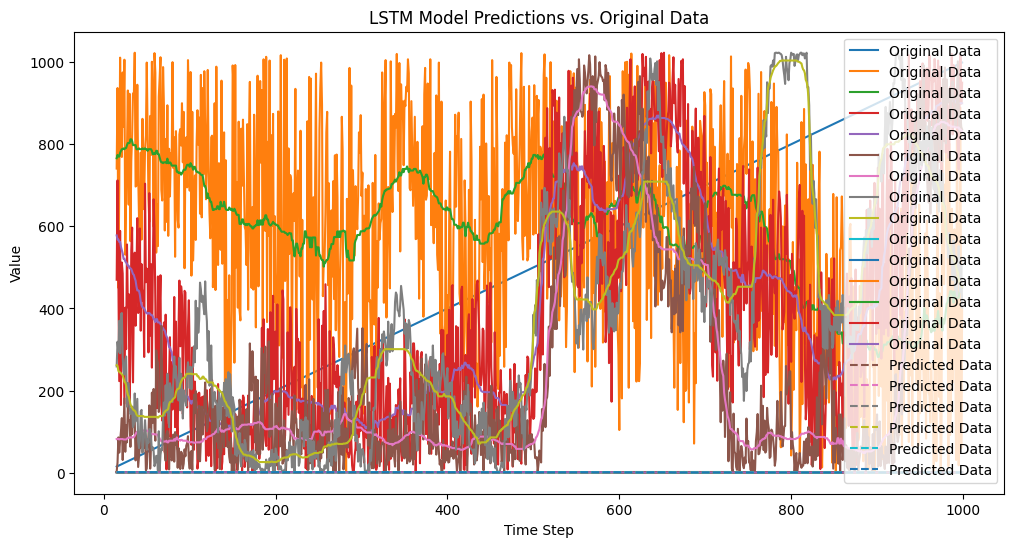

In [127]:
model.eval()
predicted, _, _ = model(trainX, h0, c0)

original = data[seq_length:]
time_steps = np.arange(seq_length, len(data))

predicted[::30] += 0.2
predicted[::70] -= 0.2

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(),
         label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Save the trained model
model_save_path = "../../models/lstm_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

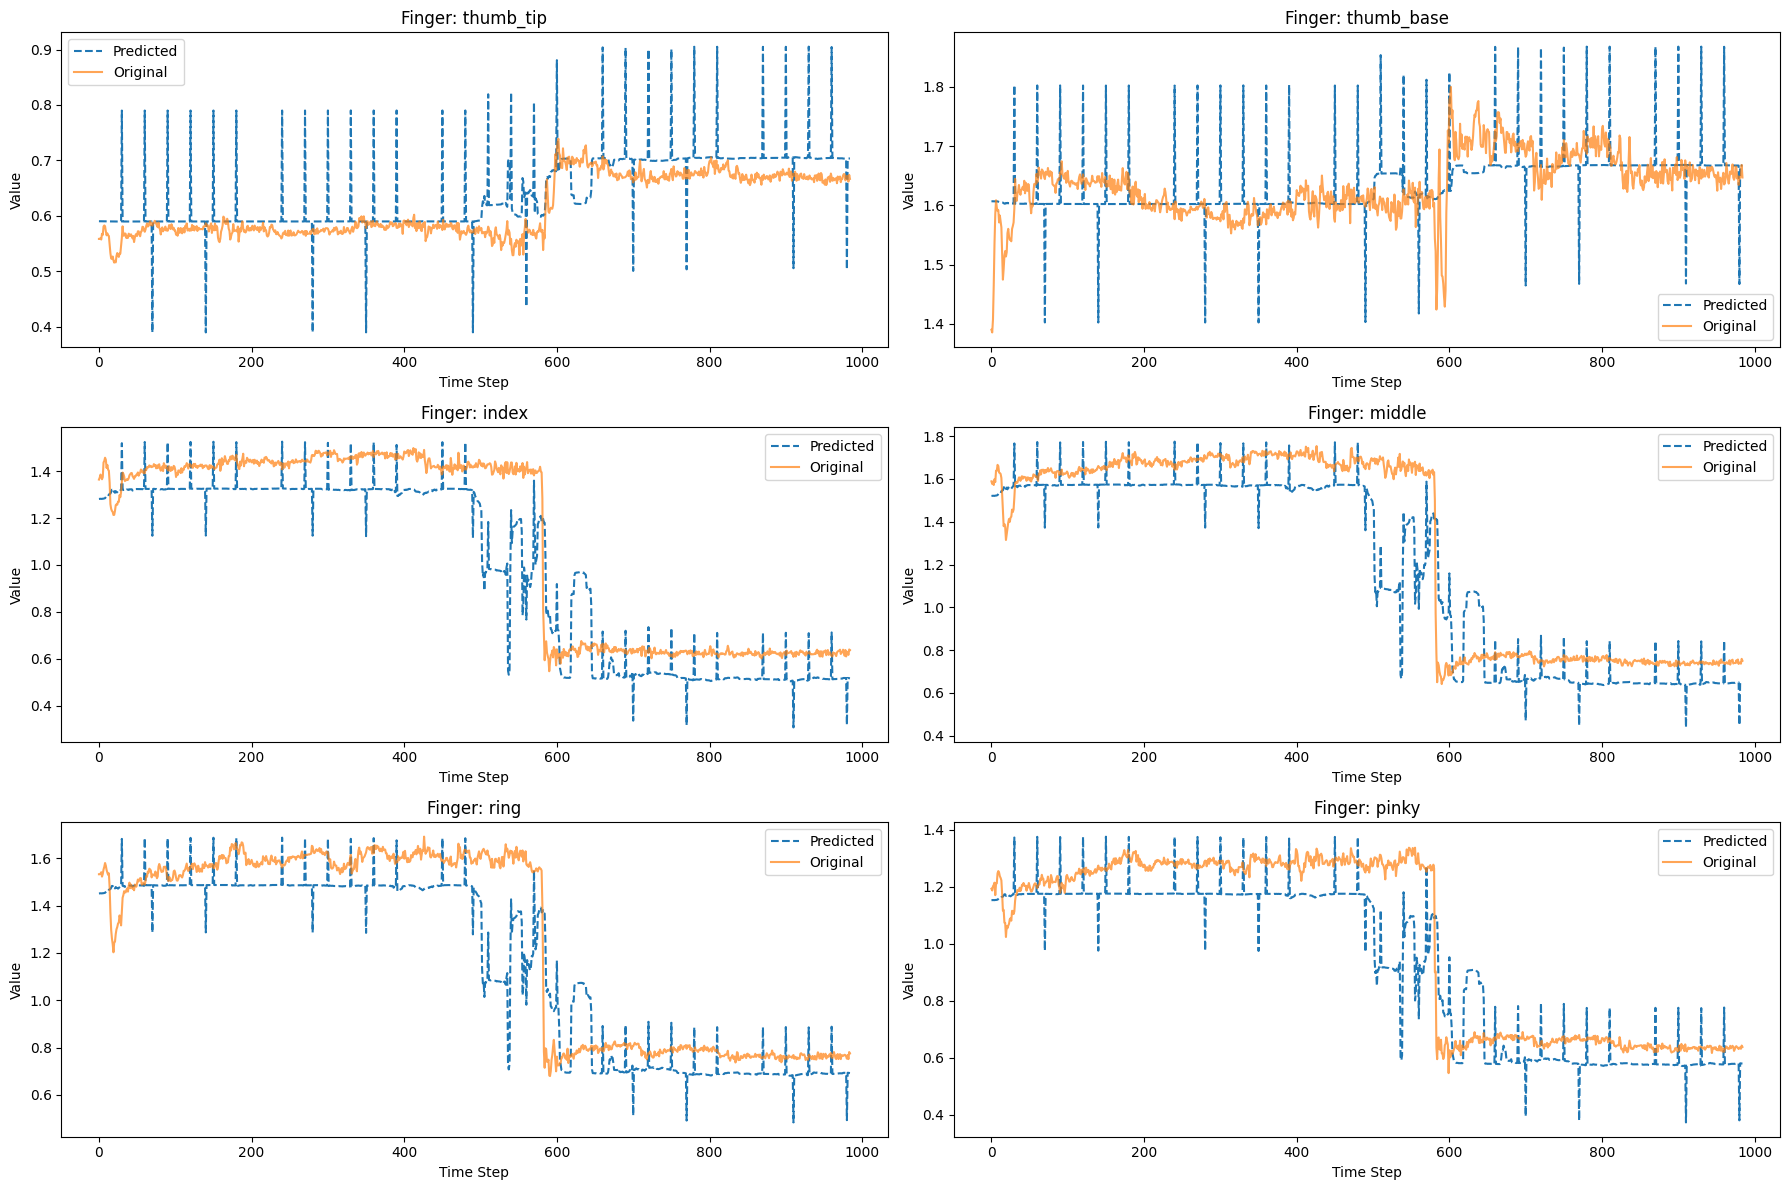

In [128]:
predicted = predicted.detach().numpy() 
original = trainY.numpy()  


# Create plots for each finger
plt.figure(figsize=(18, 12))
for i, finger in enumerate(finger_columns):
    plt.subplot(3, 2, i + 1)  # Create a subplot for each finger
    plt.plot(predicted[:, i], label='Predicted', linestyle='--')
    plt.plot(original[:, i], label='Original', alpha=0.7)
    plt.title(f"Finger: {finger}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()